In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.io as sio
import seaborn as sns
import theano

from matplotlib import cm as cm
from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 17 - The GCM model of categorization

## 17.1 The GCM model
The Generalized Context Model (GCM: Nosofsky, 1984, 1986) is an influential and empirically successful model of categorization. It is intended to explain how people make categorization decisions in a task where stimuli are presented, one at a time, over a sequence of trials, and must be classified into one of a small number of categories (usually two) based on corrective feedback.
The GCM assumes that stimuli are stored as exemplars, using their values along underlying stimulus dimensions, which correspond to points in a multidimensional psychological space. The GCM then assumes people make similarity comparisons between the current stimulus and the exemplars, and base their decision on the overall similarities to each category.

$$ c \sim \text{Uniform}(0,5) $$
$$ w \sim \text{Uniform}(0,1) $$  
$$ b = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ij} = \text{exp}[-c\,(w d^1_{ij}+(1-w)d^2_{ij})] $$  
$$ r_i = \frac{b \sum_{j}a_{j}s_{ij}}{b \sum_{j}a_{j}s_{ij}\,+\,(1-b) \sum_{j}(1-a_{j})s_{ij}}$$  
$$ y_i \sim \text{Binomial}(r_i,t)$$  

In [3]:
matdata = sio.loadmat("data/KruschkeData.mat")

nstim = 8
nsubj = 40
t = nstim * nsubj
a = matdata["a"][0]
y = matdata["y"][:, 0]

d1 = matdata["d1"]
d2 = matdata["d2"]
x = matdata["x"]

a1 = np.repeat(2 - a, nstim).reshape(nstim, nstim).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


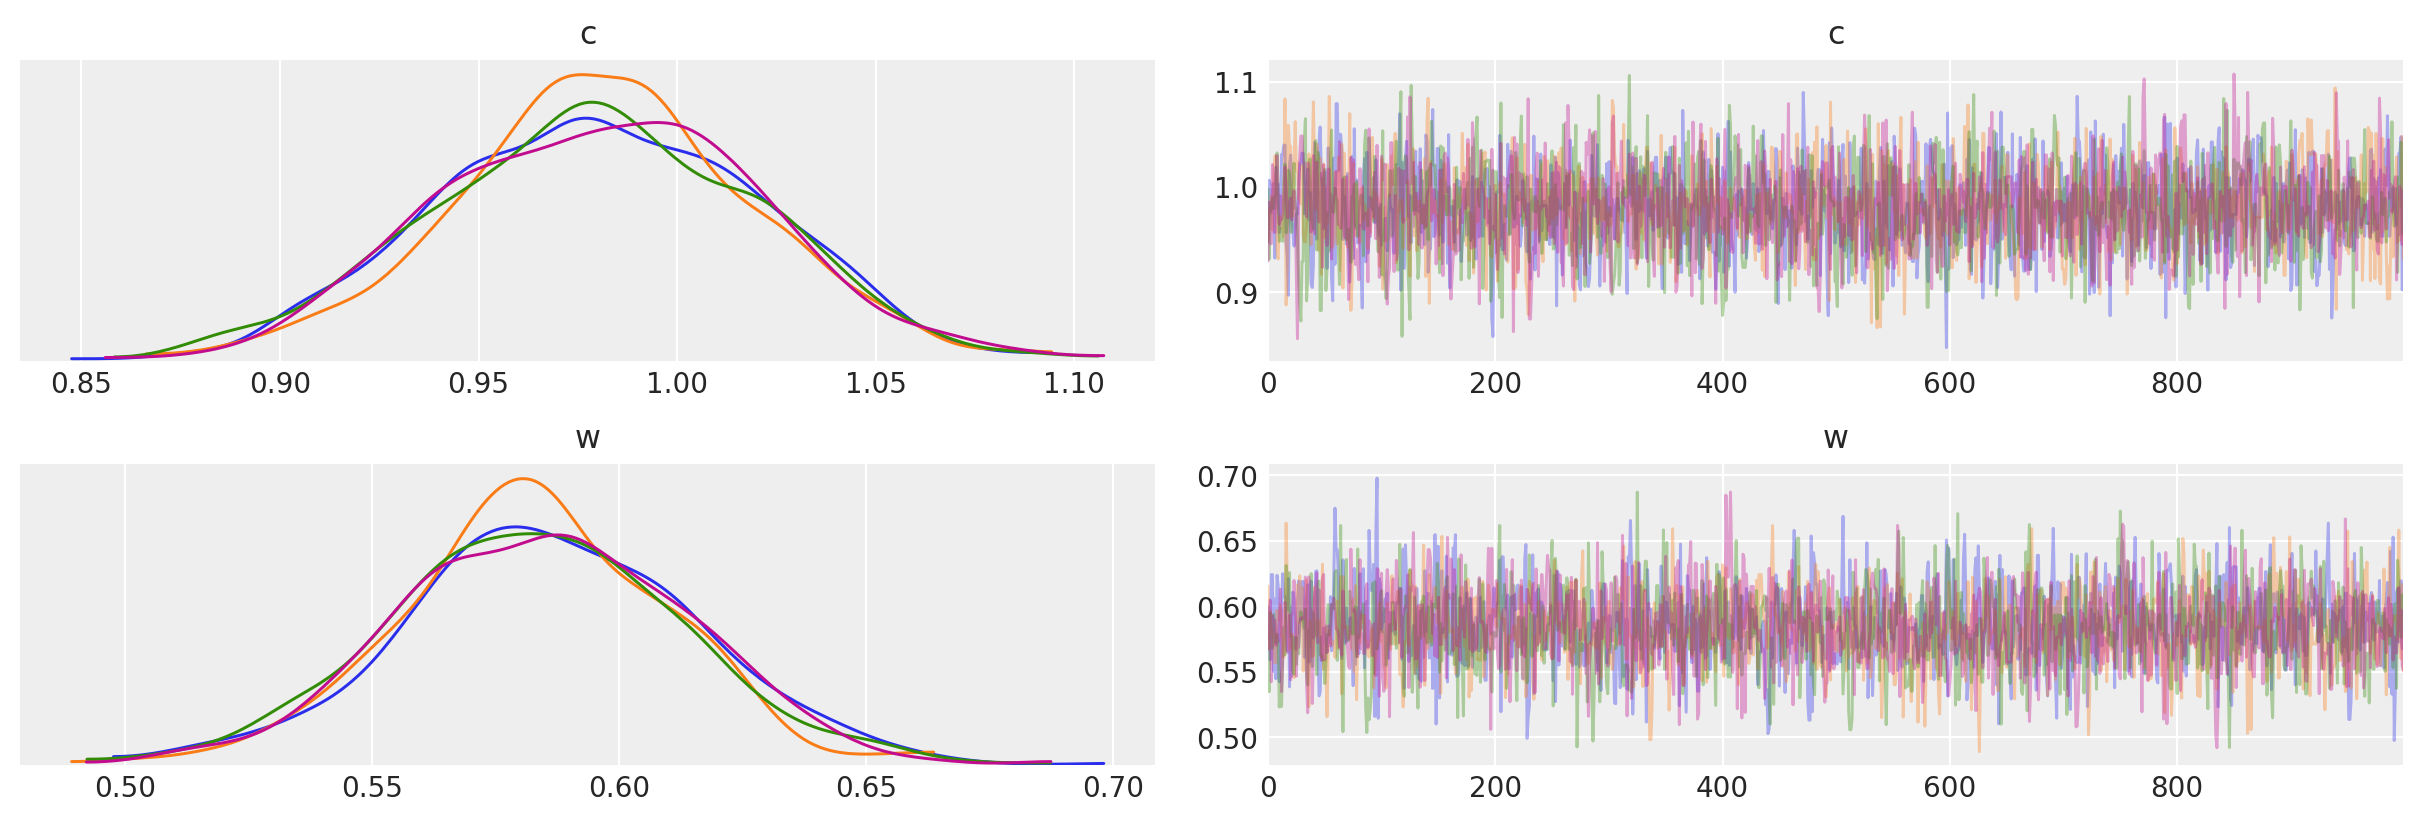

In [4]:
with pm.Model() as model1:
    c = pm.Uniform("c", lower=0, upper=5)
    w = pm.Uniform("w", lower=0, upper=1)
    b = 0.5
    sij = tt.exp(-c * (w * d1 + (1 - w) * d2))

    sum_ajsij = tt.sum(a1 * sij, axis=1)
    sum_majsij = tt.sum((1 - a1) * sij, axis=1)

    ri = pm.Deterministic("ri", (b * sum_ajsij) / (b * sum_ajsij + (1 - b) * sum_majsij))
    yi = pm.Binomial("yi", p=ri, n=t, observed=y)

    trace1 = pm.sample()

az.plot_trace(trace1, var_names=["c", "w"]);

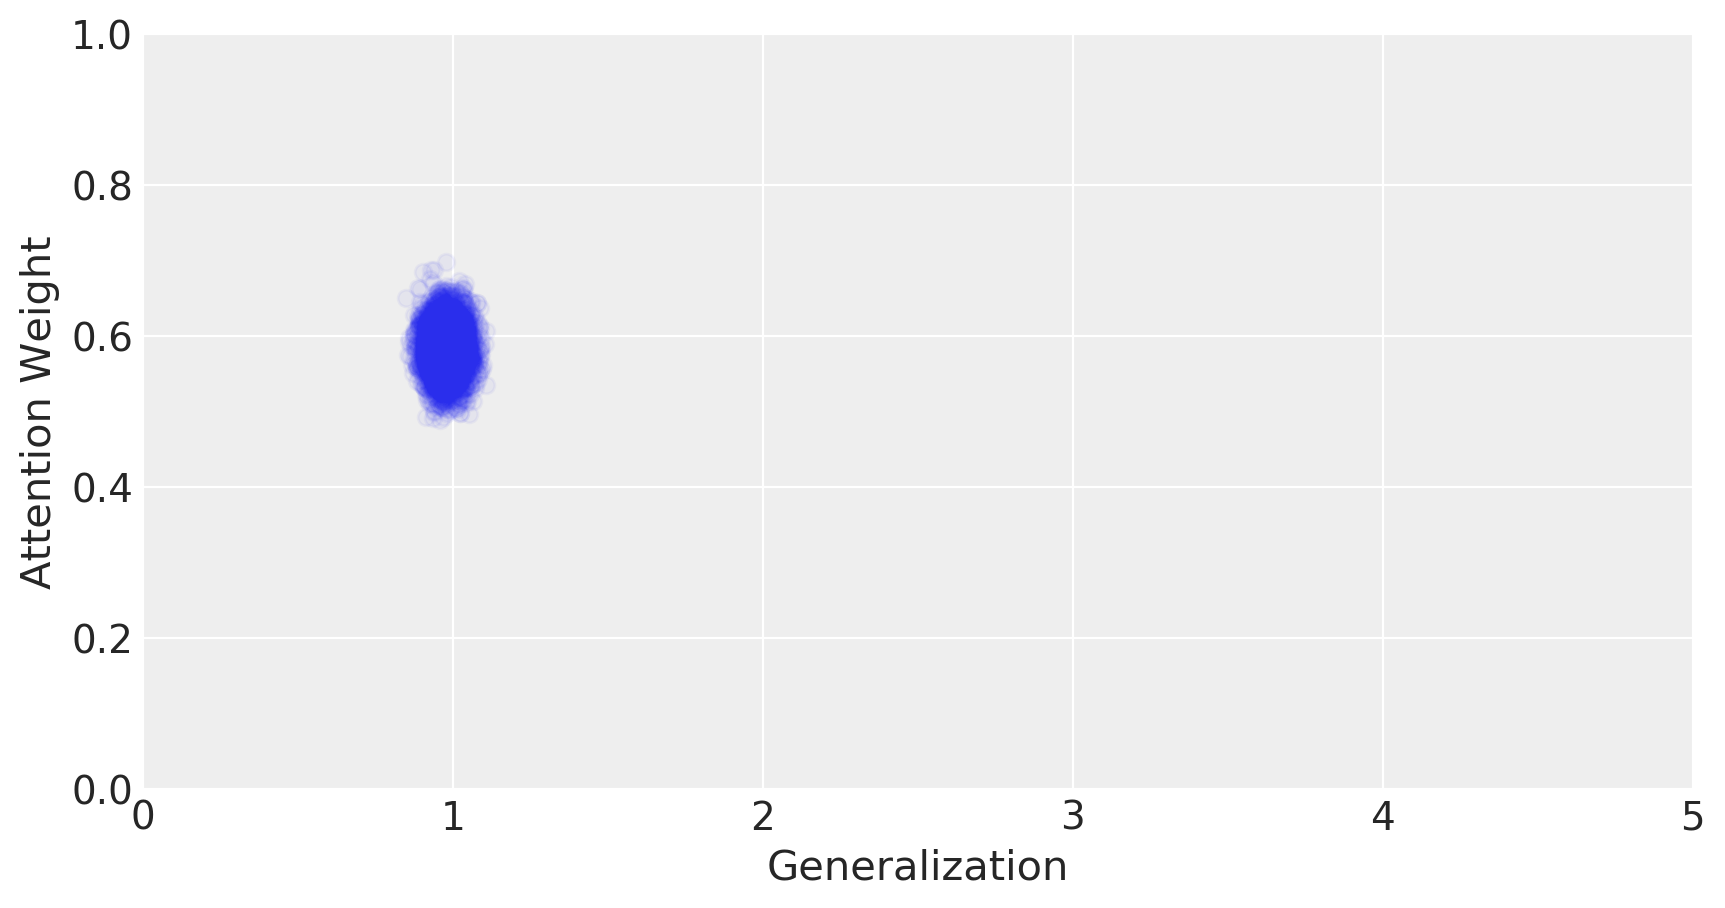

In [5]:
# Fig. 17.3
fig = plt.figure(figsize=(10, 5))
ctr = trace1["c"]
wtr = trace1["w"]
plt.scatter(ctr, wtr, alpha=0.05)
plt.xlabel("Generalization")
plt.ylabel("Attention Weight")
plt.axis((0, 5, 0, 1));

/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/pymc3/sampling.py:1585: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


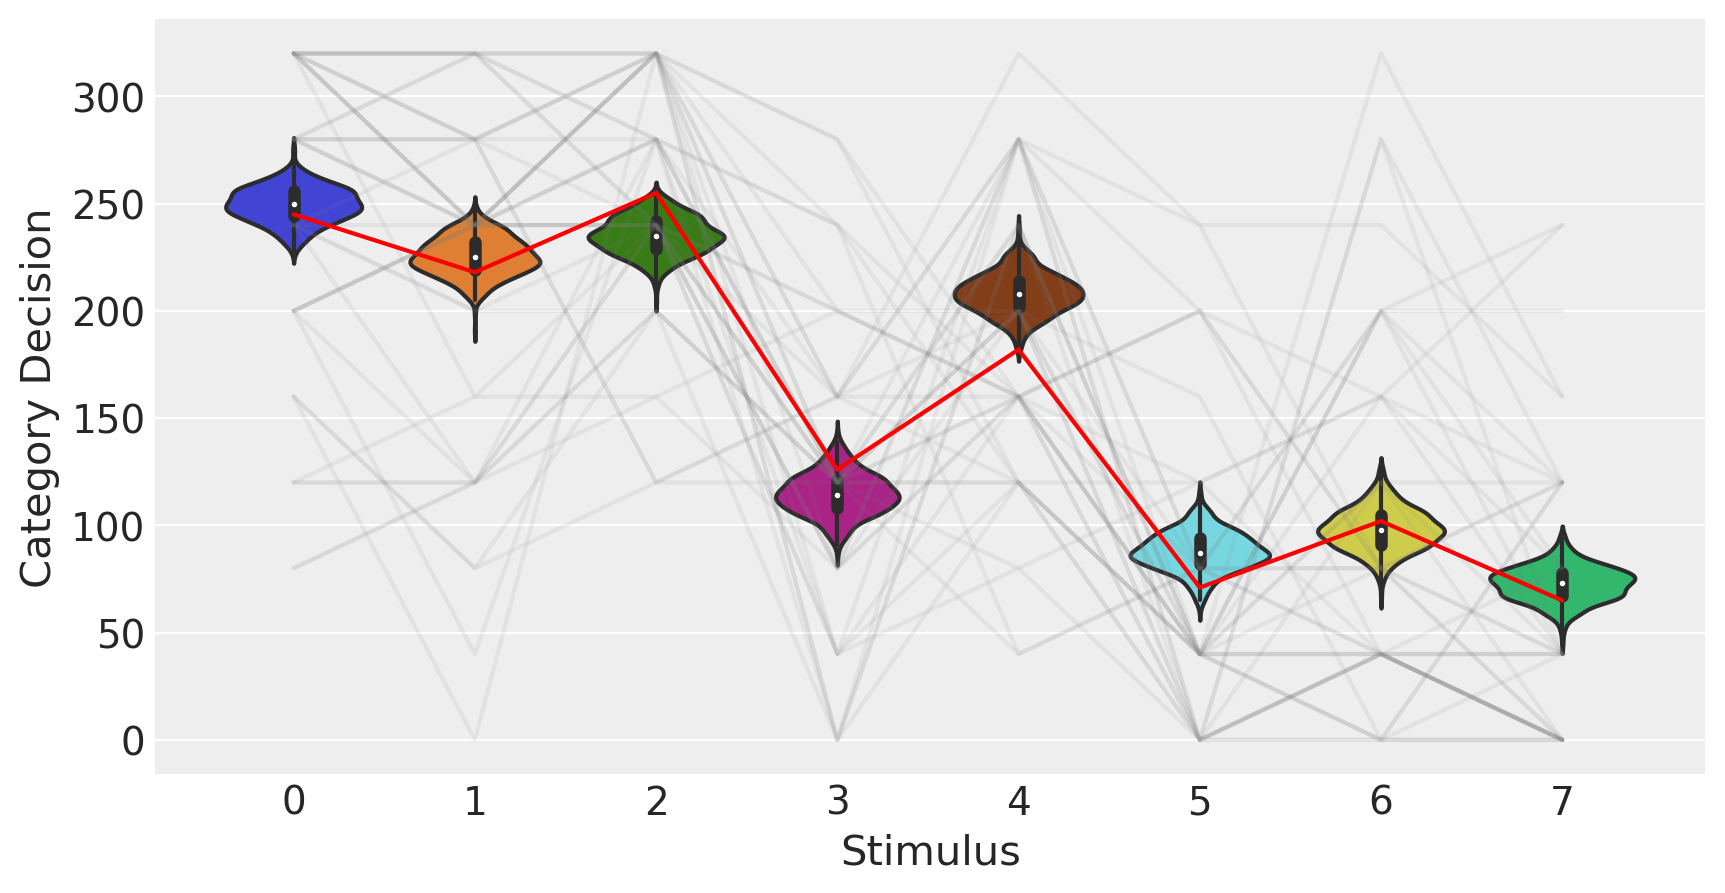

In [6]:
# Fig. 17.4
ppc = pm.sample_posterior_predictive(trace1, samples=500, model=model1)

_, axes = plt.subplots(1, 1, figsize=(10, 5))
yipred = ppc["yi"]

sns.violinplot(data=yipred, ax=axes)
axes.plot(np.float32(x).T * 40, color="gray", alpha=0.1)
axes.plot(np.mean(np.float32(x).T * 40, axis=1), color="r", alpha=1)

axes.set_xticks(np.arange(8), "".join(map(str, np.arange(1, 9))))
axes.set_yticks([0, t], ("B", "A"))
axes.set_xlabel("Stimulus")
axes.set_ylabel("Category Decision");

## 17.2 Individual differences in the GCM


$$ c_k \sim \text{Uniform}(0,5) $$
$$ w_k \sim \text{Uniform}(0,1) $$  
$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  
$$ r_{ik} = \frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}$$  
$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

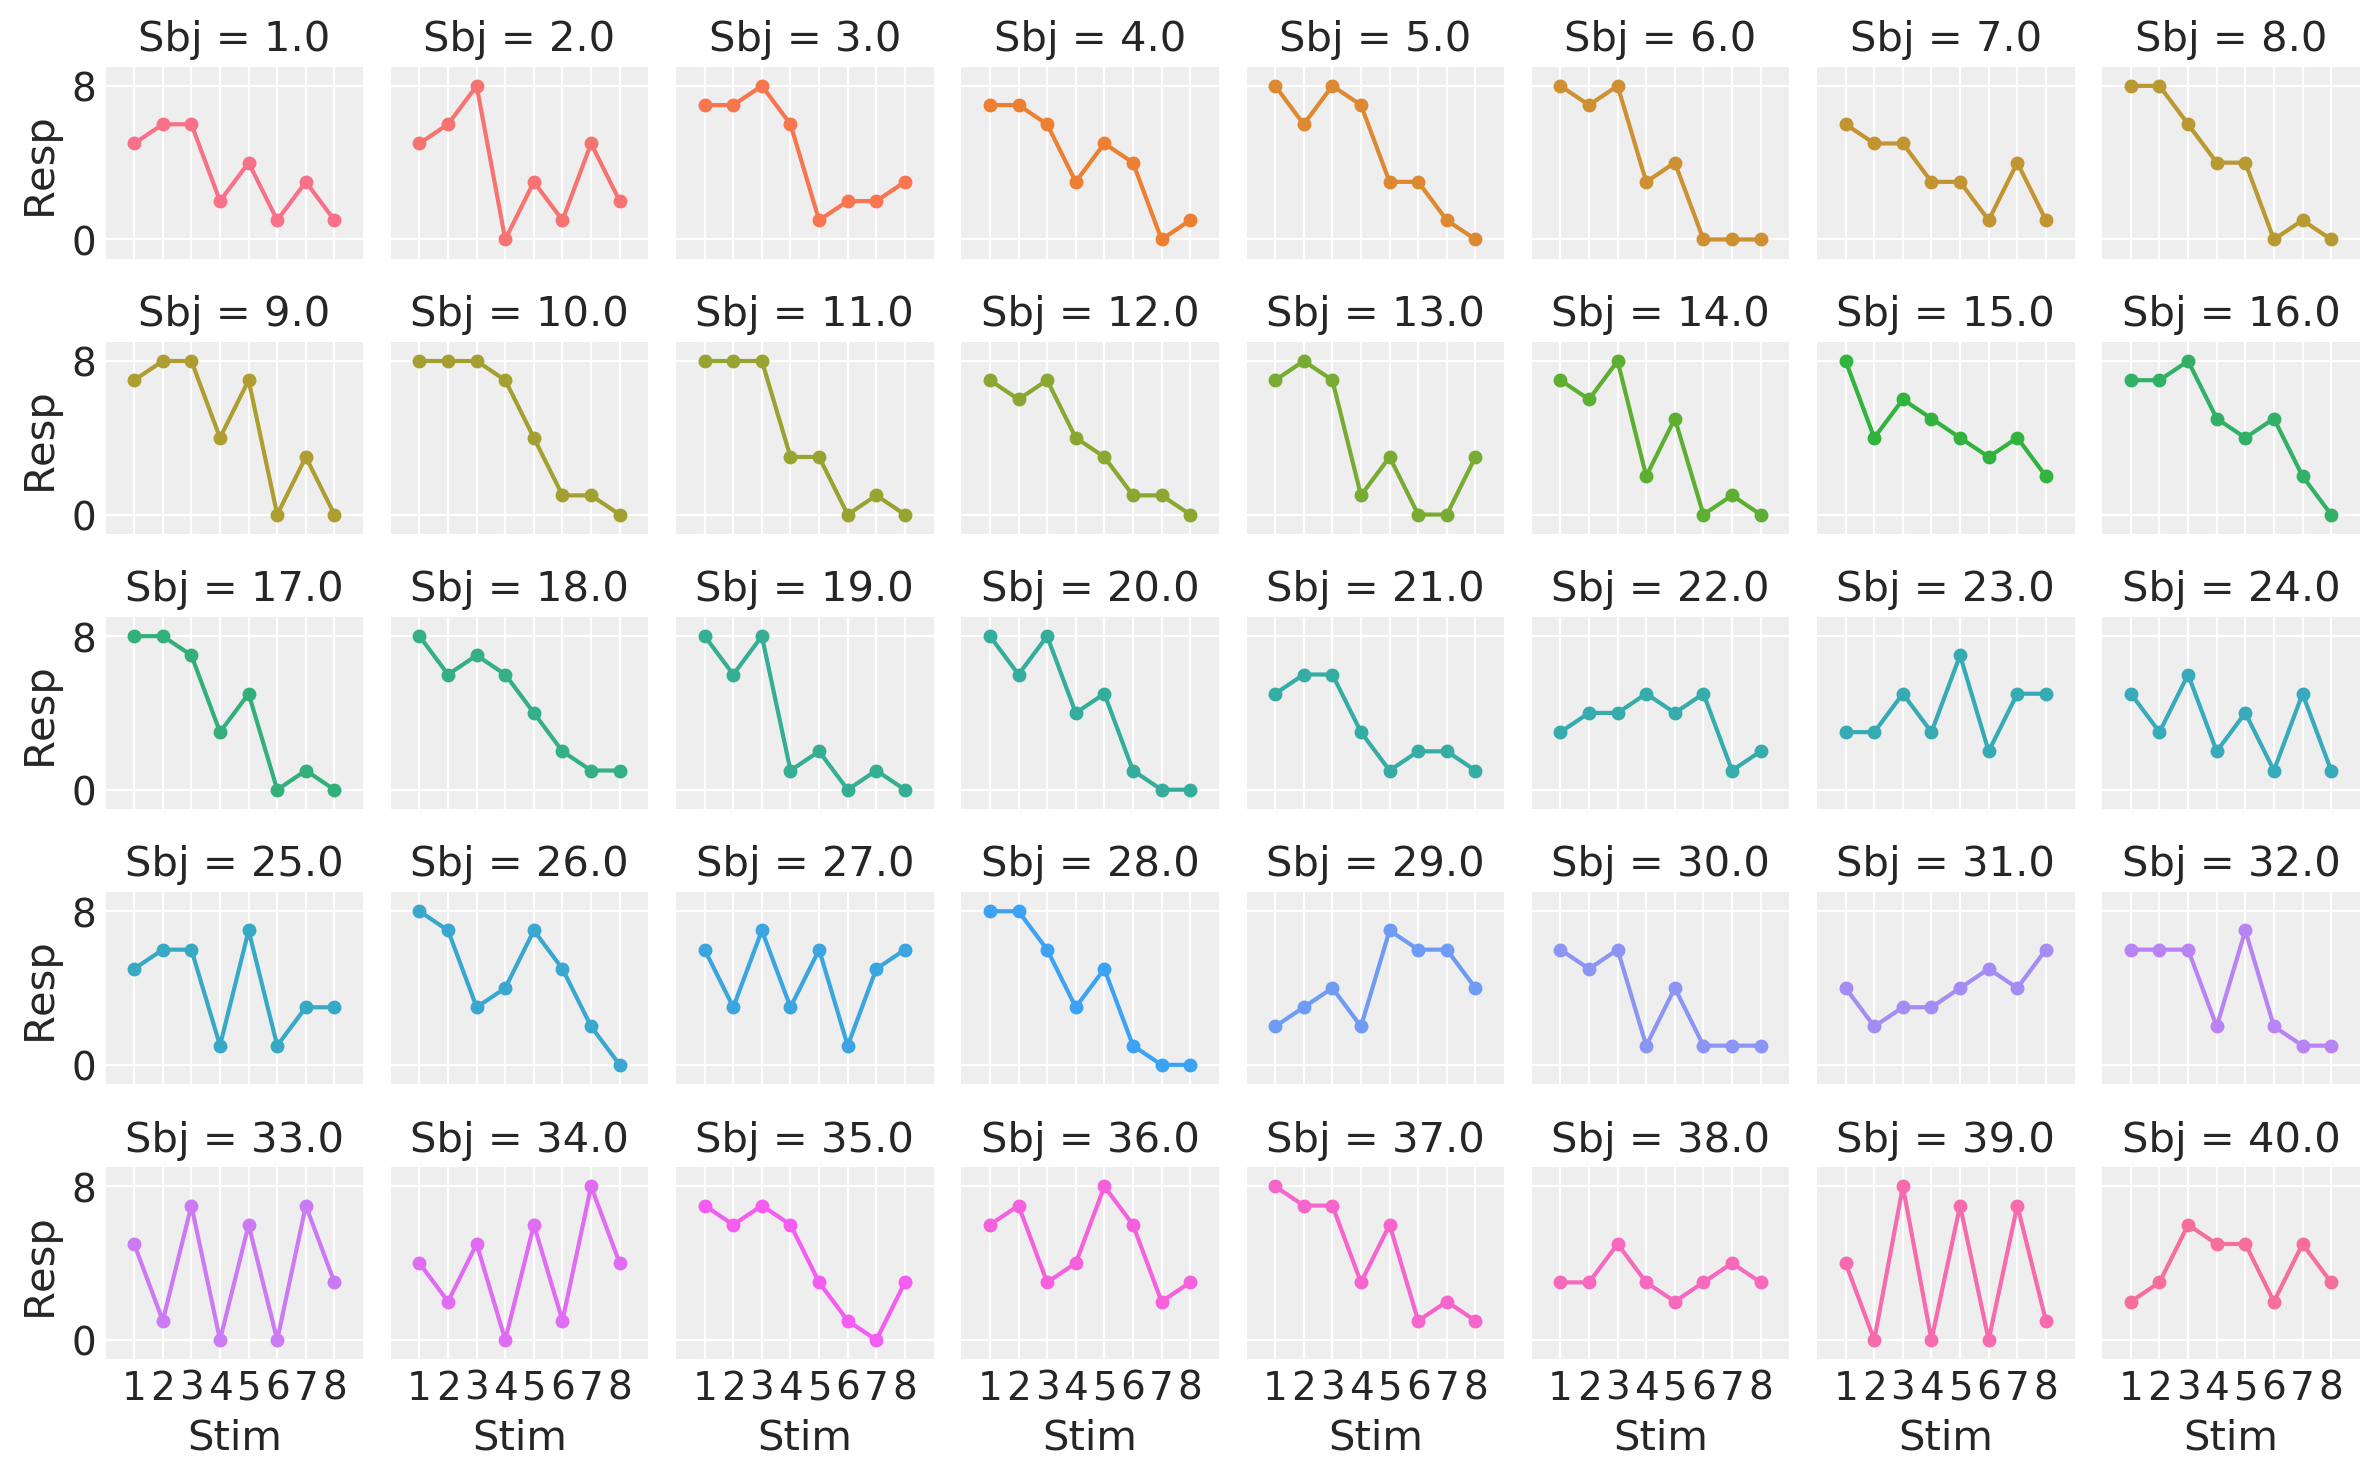

In [7]:
# Fig. 17.5
# Create a dataset with many short random walks
x2 = np.float32(x)
subjvect = []
stimvect = []
respvect = []
for i in range(nstim):
    for j in range(nsubj):
        subjvect.append(j + 1)
        stimvect.append(i + 1)
        respvect.append(x2[j, i])
df = pd.DataFrame(np.c_[respvect, stimvect, subjvect], columns=["Resp", "Stim", "Sbj"])

grid = sns.FacetGrid(df, col="Sbj", hue="Sbj", col_wrap=8, height=1.5)
grid.map(plt.plot, "Stim", "Resp", marker="o", ms=4)
# Adjust the tick positions and labels
grid.set(xticks=np.arange(1, 9), yticks=[0, 8], xlim=(0, 9), ylim=(-1, 9))
# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1);

In [8]:
a1 = np.tile(2 - a, [nstim, 1])[:, :, np.newaxis]
y2 = x2.transpose()
d1_t = np.tile(d1[:, :, np.newaxis], [1, 1, nsubj])
d2_t = np.tile(d2[:, :, np.newaxis], [1, 1, nsubj])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


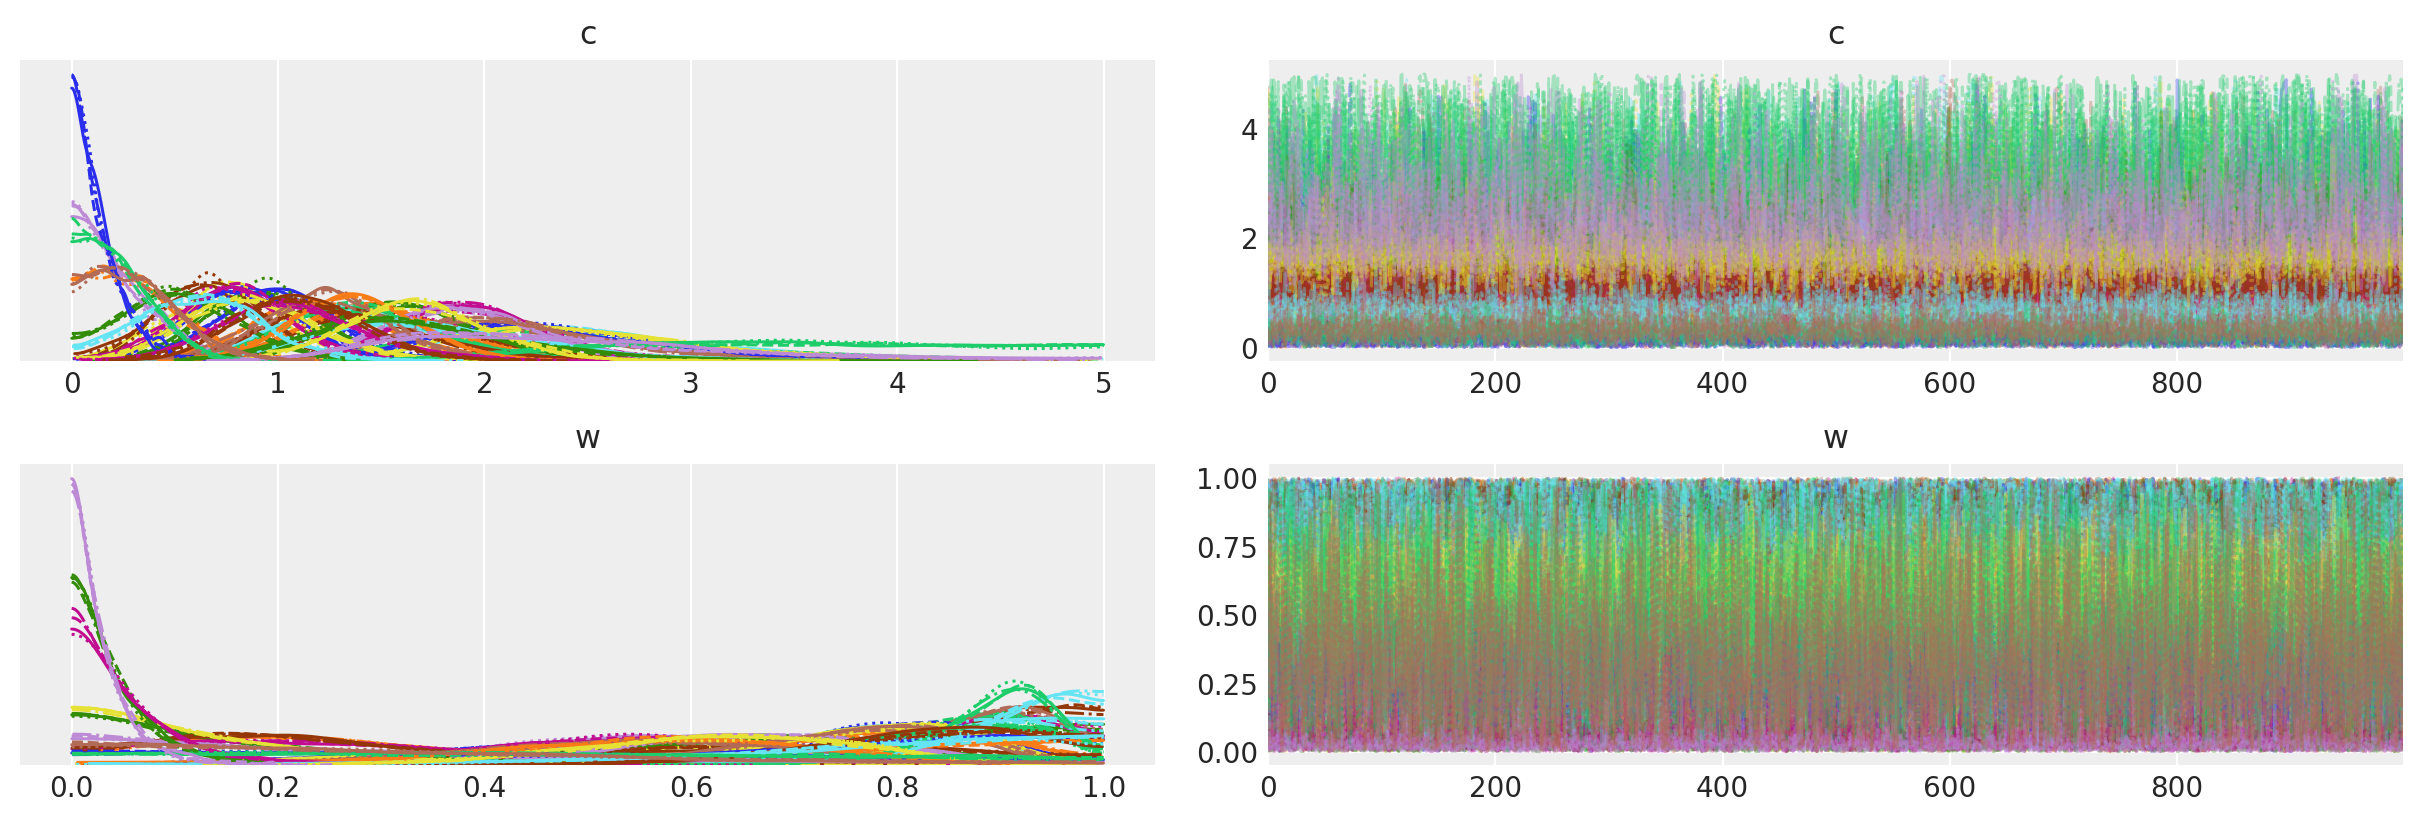

In [9]:
with pm.Model() as model2:
    c = pm.Uniform("c", lower=0, upper=5, shape=(1, 1, nsubj))
    w = pm.Uniform("w", lower=0, upper=1, shape=(1, 1, nsubj))
    b = 0.5

    sij = tt.exp(-c * (w * d1_t + (1 - w) * d2_t))

    sum_ajsij = tt.sum(a1 * sij, axis=1)
    sum_majsij = tt.sum((1 - a1) * sij, axis=1)

    ri = pm.Deterministic("ri", (b * sum_ajsij) / (b * sum_ajsij + (1 - b) * sum_majsij))

    yi = pm.Binomial("yi", p=ri, n=nstim, observed=y2)

    trace2 = pm.sample()

az.plot_trace(trace2, var_names=["c", "w"], compact=True);

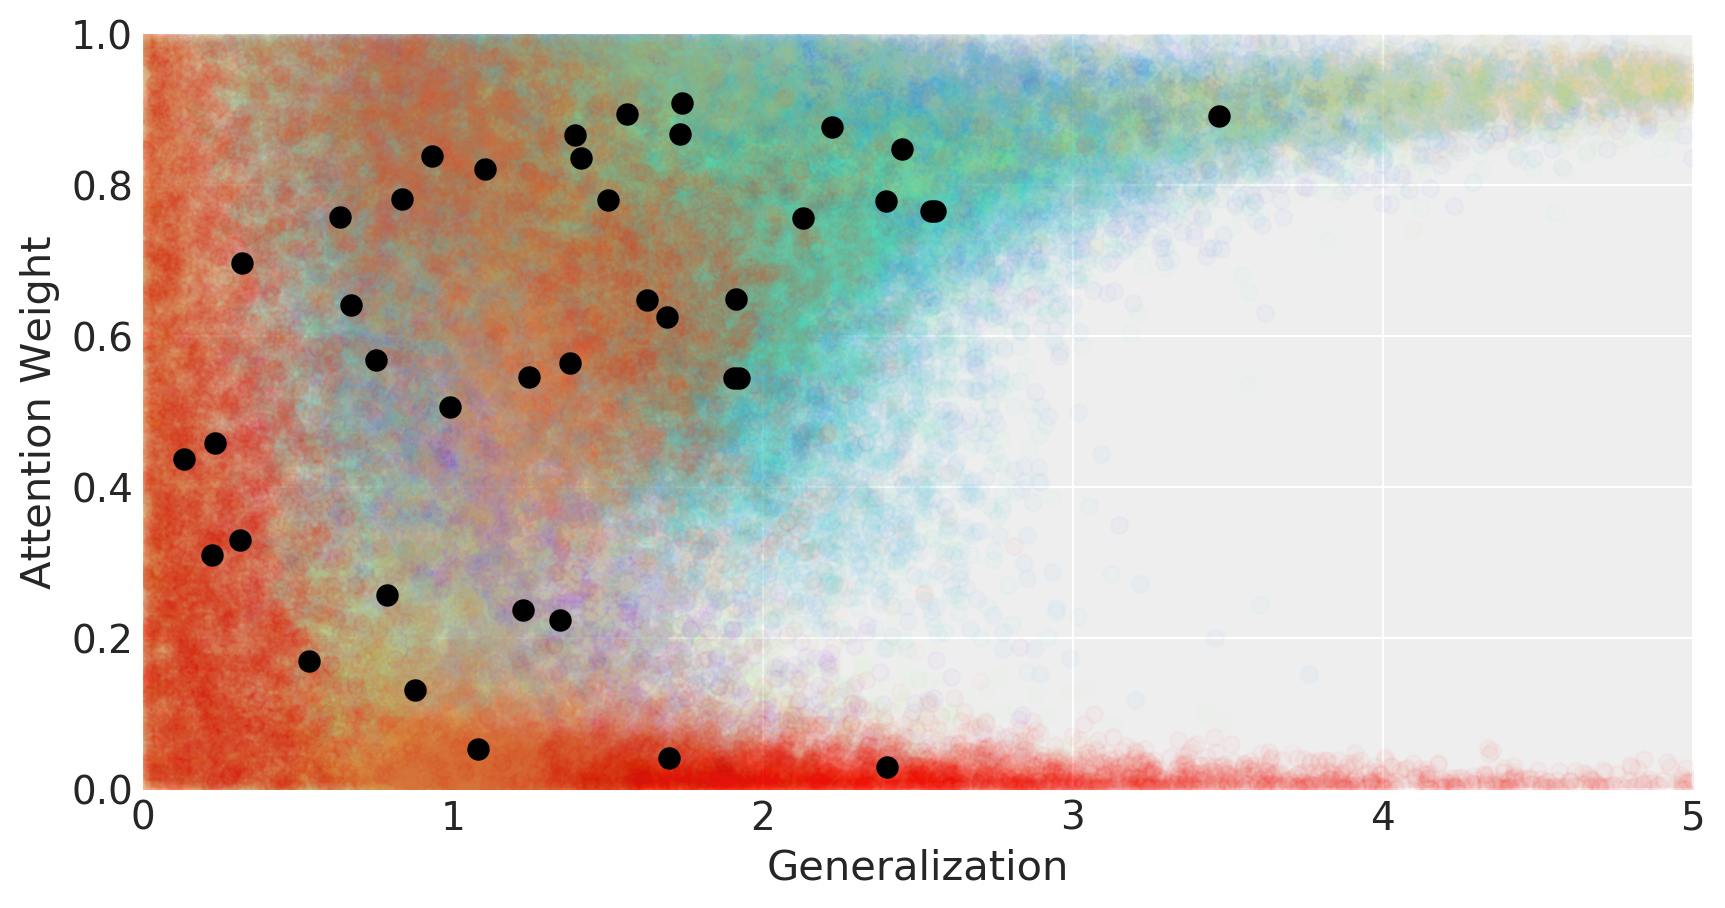

In [10]:
# Fig. 17.7
fig = plt.figure(figsize=(10, 5))
ctr = np.squeeze(trace2["c"])
wtr = np.squeeze(trace2["w"])

colors = cm.rainbow(np.linspace(0, 1, nsubj))
for i in range(nsubj):
    plt.scatter(ctr[:, i], wtr[:, i], color=colors[i], alpha=0.025)

plt.scatter(np.mean(ctr, axis=0), np.mean(wtr, axis=0), s=50, color="black", alpha=1)
plt.xlabel("Generalization")
plt.ylabel("Attention Weight")
plt.grid("off")
plt.axis((0, 5, 0, 1));

## 17.3 Latent groups in the GCM


$$ \mu_{1}^w,\delta \sim \text{Uniform}(0,1)$$
$$ \mu_{2}^w = \text{min}(1,\mu_{1}^w+\delta) $$
$$ \sigma^w \sim \text{Uniform}(0.01,1)$$
$$ \mu^c \sim \text{Uniform}(0,5)$$
$$ \sigma^c \sim \text{Uniform}(0.01,3)$$
$$ \phi^c,\phi^g \sim \text{Uniform}(0,1)$$
$$ z_{k}^c \sim \text{Bernoulli}(\phi^c)$$
$$ z_{k}^g \sim \text{Bernoulli}(\phi^g)$$

$$ c_k \sim \text{Gaussian}(\mu^c,\frac{1}{(\sigma^c)^2})_{\mathcal I(0,5)} $$
$$ w_k \sim
\begin{cases}
\text{Gaussian}(\mu_{1}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 0$} \\
\text{Gaussian}(\mu_{2}^w,\frac{1}{(\sigma^w)^2})_{\mathcal I(0,1)}  & \text{if $z_{k}^c = 0,z_{k}^g = 1$}
\end{cases}  $$

$$ b_k = \frac{1}{2}$$  
$$ d_{ij}^m = \lvert p_{im} - p_{jm}\rvert $$  
$$ s_{ijk} = \text{exp}[-c_k\,(w_k d^1_{ij}+(1-w_k)d^2_{ij})] $$  

$$ r_{ik} =
\begin{cases}
\frac{b_k \sum_{j}a_{j}s_{ijk}}{b_k \sum_{j}a_{j}s_{ijk}\,+\,(1-b_k) \sum_{j}(1-a_{j})s_{ijk}}  & \text{if $z_{k}^c = 0$} \\
\frac{1}{2}  & \text{if $z_{k}^c = 1$}
\end{cases}  $$


$$ y_{ik} \sim \text{Binomial}(r_{ik},n)$$  

In [11]:
with pm.Model() as model3:
    mu1w = pm.Uniform("mu1w", lower=0, upper=1, testval=0.05)
    delta = pm.Uniform("delta", lower=0, upper=1, testval=0.75)
    mu2w = pm.Deterministic("mu2w", tt.clip(mu1w + delta, 0, 1))

    sigmaw = pm.Uniform("sigmaw", lower=0.01, upper=1, testval=0.05)
    muc = pm.Uniform("muc", lower=0, upper=5, testval=1.4)
    sigmac = pm.Uniform("sigmac", lower=0.01, upper=3, testval=0.45)

    phic = pm.Uniform("phic", lower=0, upper=1, testval=0.1)
    phig = pm.Uniform("phig", lower=0, upper=1, testval=0.8)

    zck = pm.Bernoulli("zck", p=phic, shape=nsubj)
    zcg = pm.Bernoulli("zcg", p=phig, shape=nsubj)
    b = 0.5

    c = tt.clip(pm.Normal("c", mu=muc, sd=sigmac, shape=(1, 1, nsubj)), 0, 5)
    muw = pm.Deterministic("muw", tt.switch(tt.eq(zcg, 0), mu1w, mu2w))
    w = tt.clip(pm.Normal("w", mu=muw, sd=sigmaw, shape=(1, 1, nsubj)), 0, 1)

    sij = tt.exp(-c * (w * d1_t + (1 - w) * d2_t))

    sum_ajsij = tt.sum(a1 * sij, axis=1)
    sum_majsij = tt.sum((1 - a1) * sij, axis=1)

    ri1 = pm.Deterministic("ri1", (b * sum_ajsij) / (b * sum_ajsij + (1 - b) * sum_majsij))
    ri2 = tt.constant(np.ones((nstim, nsubj)) * 0.5)
    ri = pm.Deterministic("ri", tt.squeeze(tt.switch(tt.eq(zck, 0), ri1, ri2)))

    yi = pm.Binomial("yi", p=ri, n=nstim, observed=y2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w, c, phig, phic, sigmac, muc, sigmaw, delta, mu1w]
>BinaryGibbsMetropolis: [zck, zcg]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 808 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


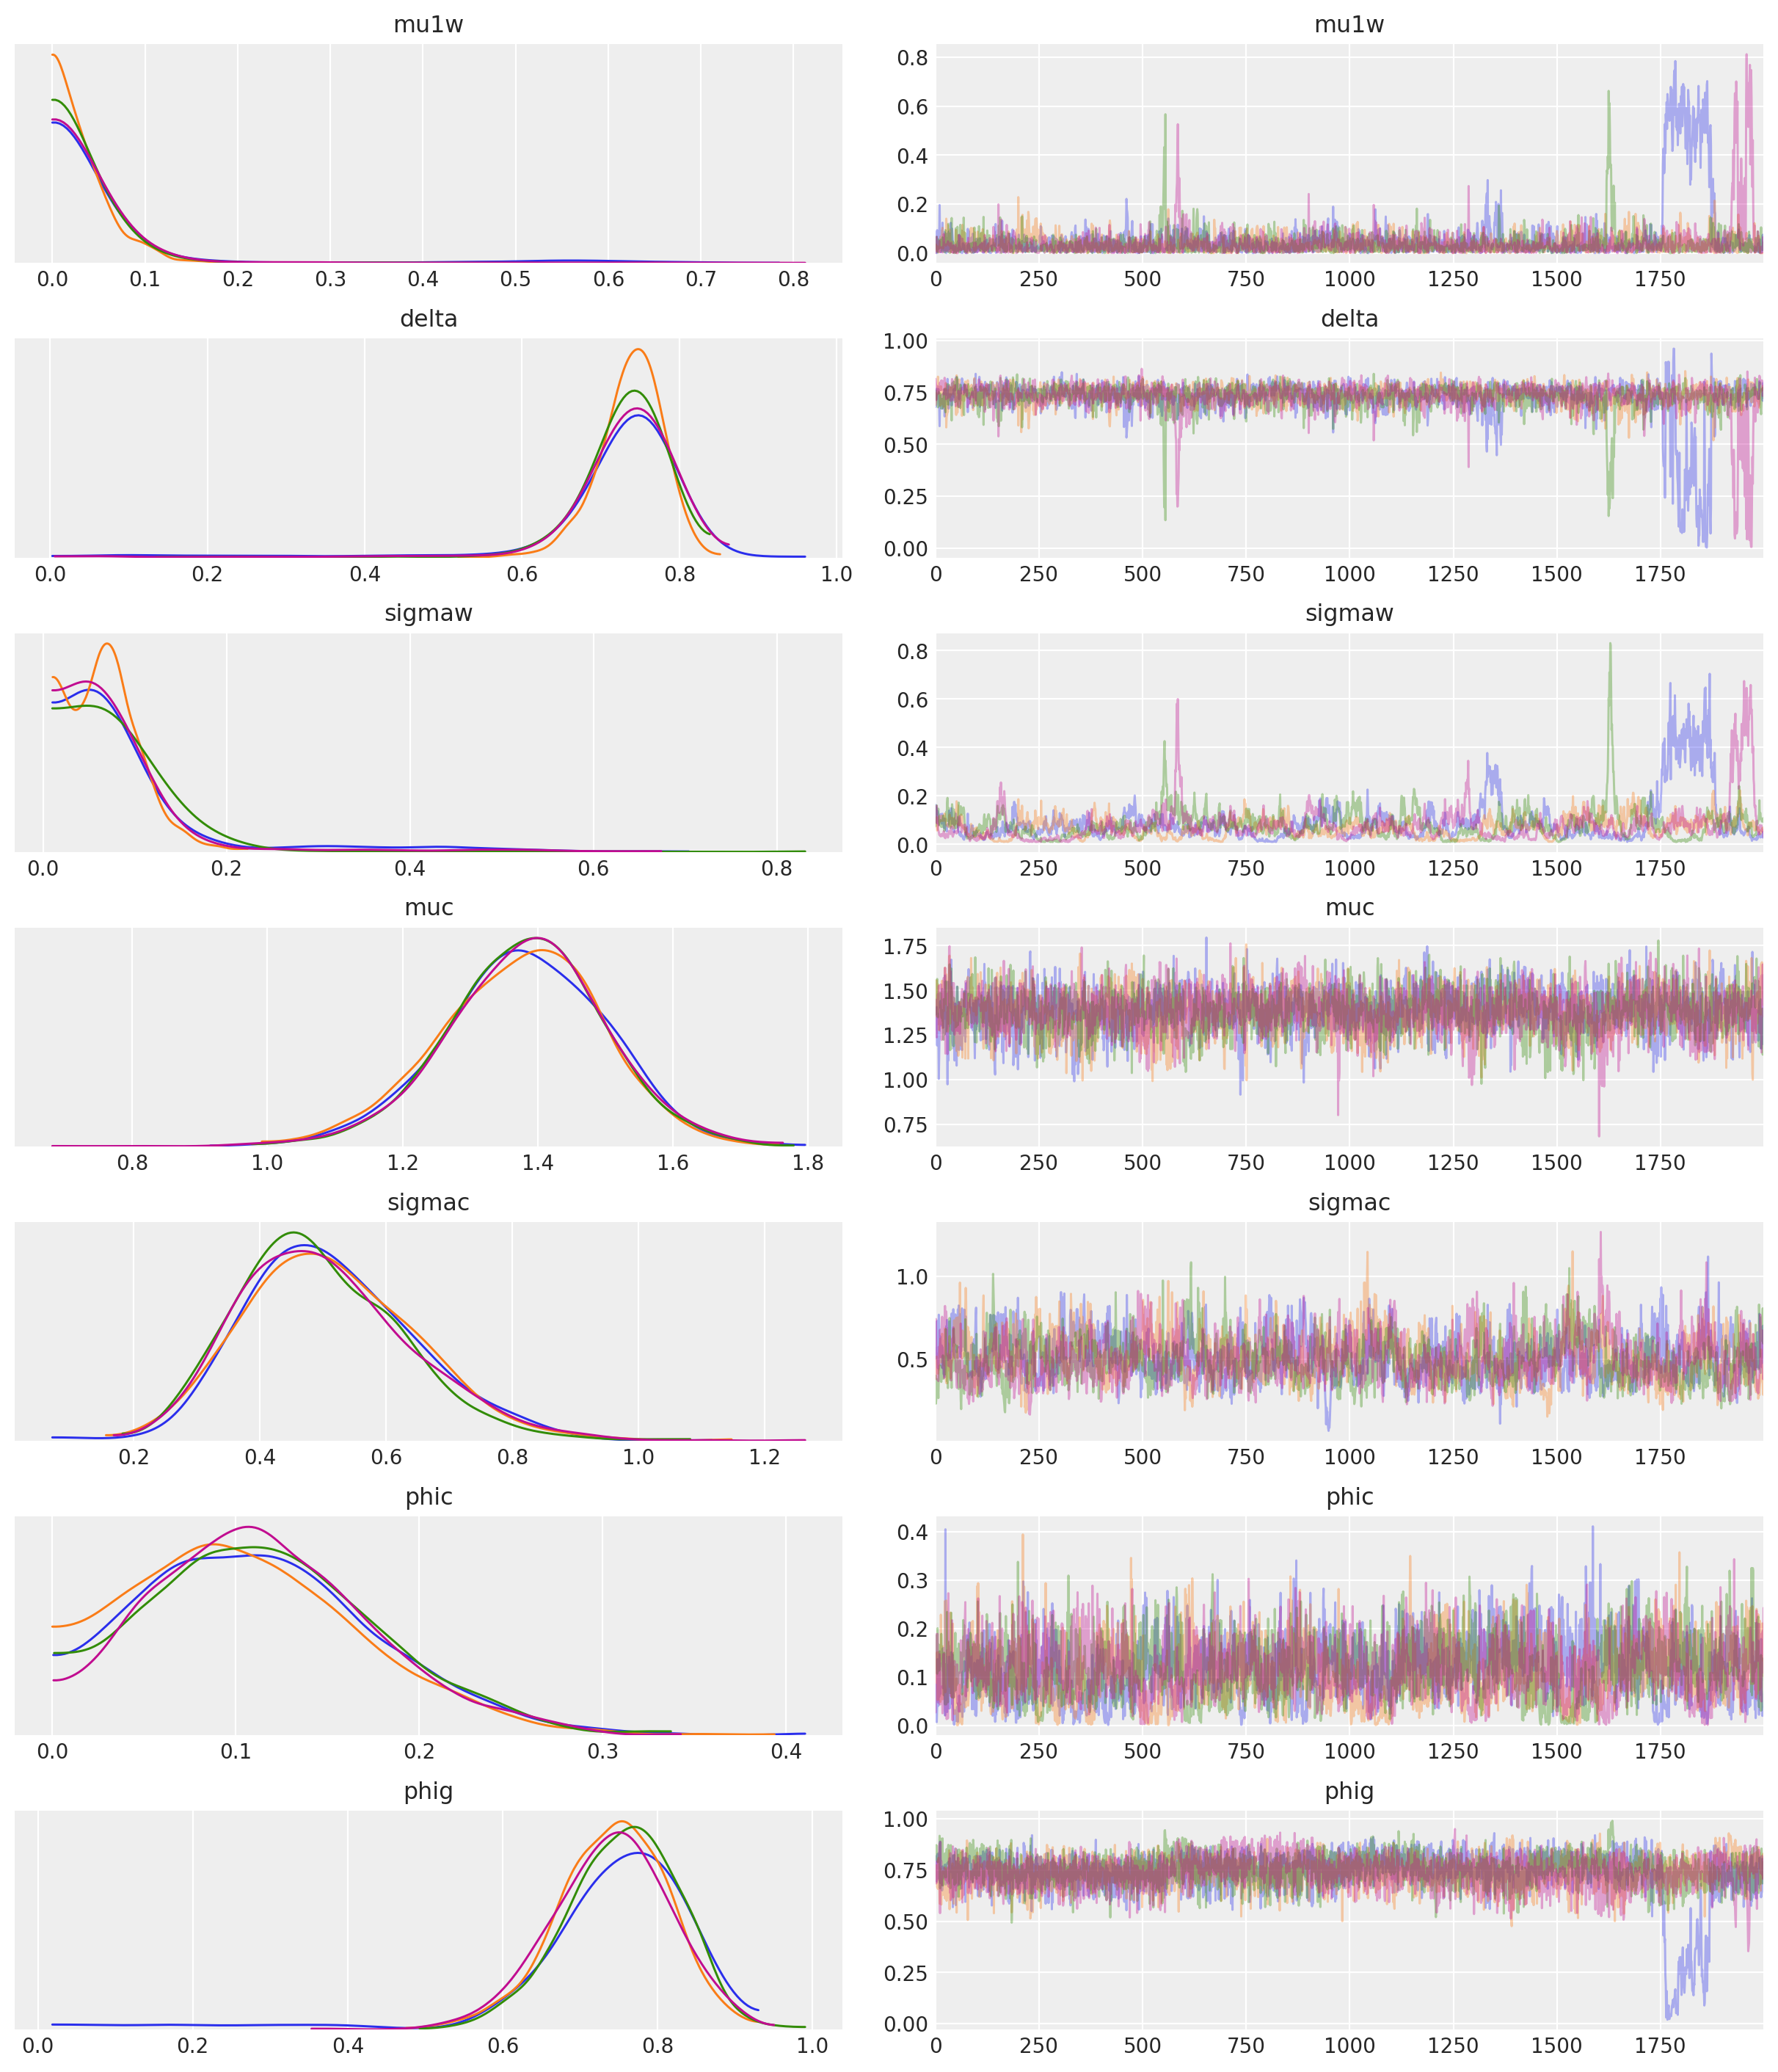

In [12]:
with model3:
    step = pm.NUTS(target_accept=0.99)
    trace3 = pm.sample(2000, tune=4000, step=step)

#     # Using ADVI
#     s = theano.shared(pm.floatX(1))
#     inference = pm.ADVI(cost_part_grad_scale=s)
#     # ADVI has nearly converged
#     inference.fit(n=20000)
#     # It is time to set `s` to zero
#     s.set_value(0)
#     approx = inference.fit(n=10000)
#     trace3 = approx.sample_vp(3000)
#     elbos1 = -inference.hist

az.plot_trace(trace3, var_names=["mu1w", "delta", "sigmaw", "muc", "sigmac", "phic", "phig"]);

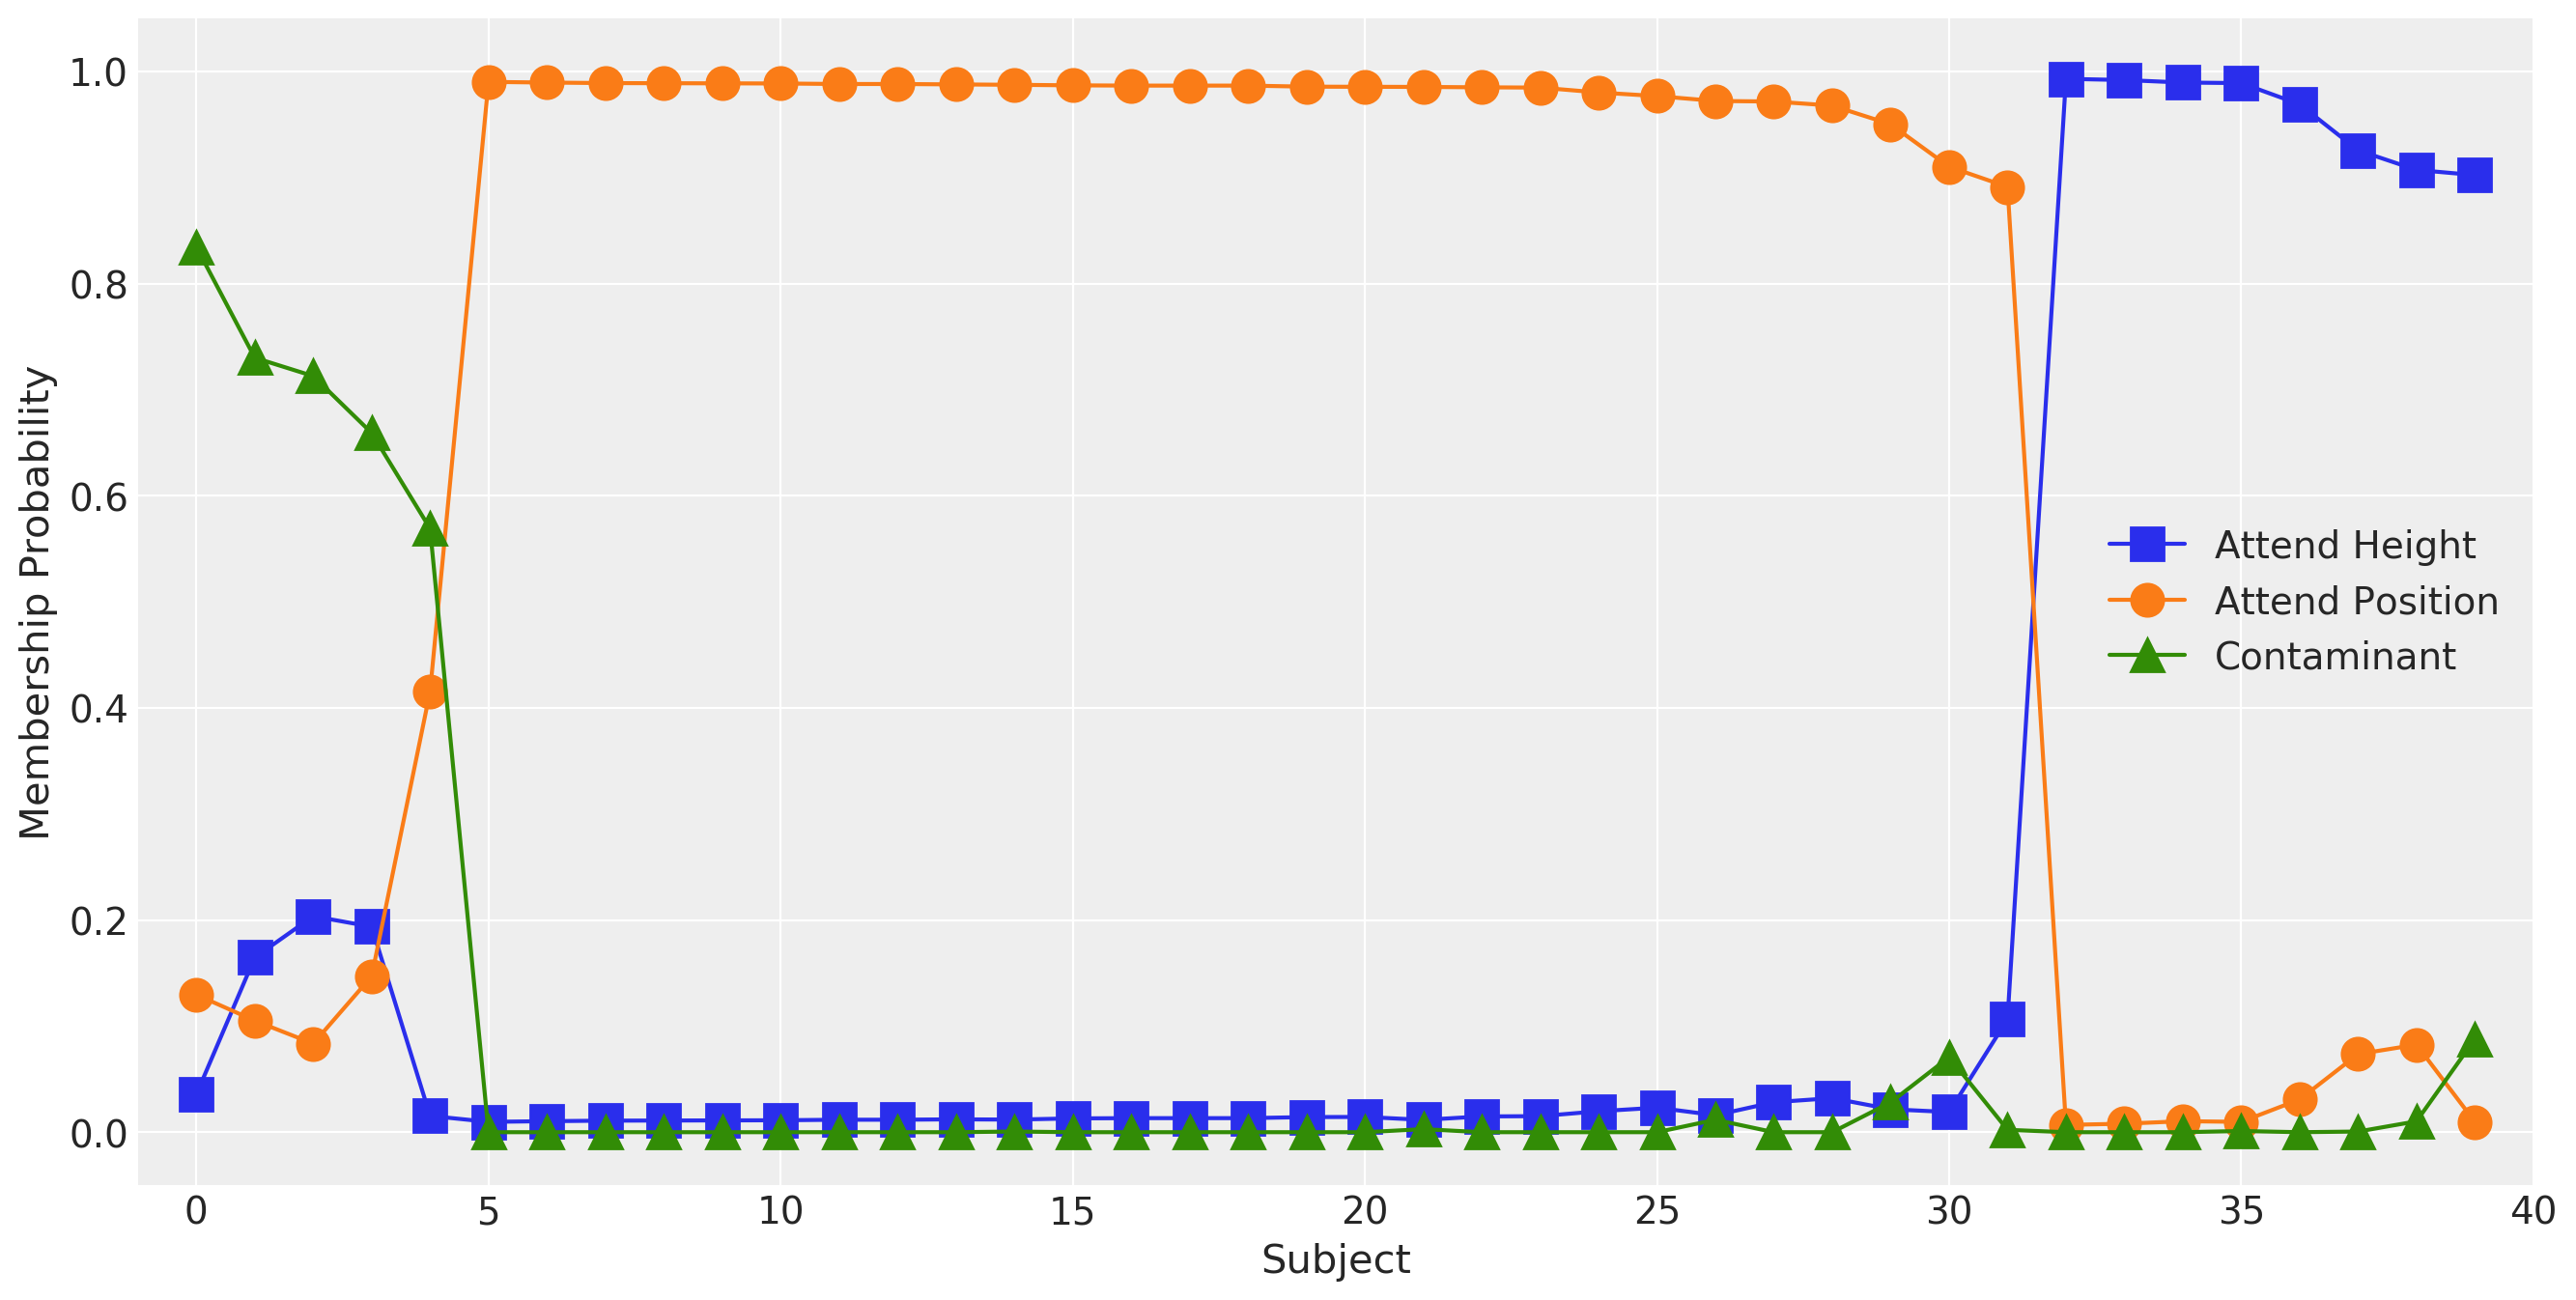

In [13]:
# Fig. 17.9
zc = np.squeeze(trace3["zck"])
zg = np.squeeze(trace3["zcg"])
z = (zc == 0) * (zg + 1) + 3 * (zc == 1)
z1 = np.zeros((nsubj, 3))

for i in range(nsubj):
    sbjid = z[:, i]
    z1[i] = [
        np.sum(sbjid == 1) / len(sbjid),
        np.sum(sbjid == 2) / len(sbjid),
        np.sum(sbjid == 3) / len(sbjid),
    ]
ord1 = []

for i in range(3):
    ordtmp = np.argsort(z1[:, i])
    ordtmp = ordtmp[z1[ordtmp, i] > 0.5]
    ord1.extend(ordtmp)
ord1 = np.asarray(ord1)
fig = plt.figure(figsize=(16, 8))

xpl = np.arange(40)[::-1]
plt.plot(xpl, z1[ord1, 0], marker="s", markersize=12)
plt.plot(xpl, z1[ord1, 1], marker="o", markersize=12)
plt.plot(xpl, z1[ord1, 2], marker="^", markersize=12)
plt.legend(["Attend Height", "Attend Position", "Contaminant"])
plt.ylim([-0.05, 1.05])
plt.xlim([-1, 40])
plt.xlabel("Subject")
plt.ylabel("Membership Probability");

/Users/alex_andorra/opt/anaconda3/envs/BCM_pymc3/lib/python3.7/site-packages/pymc3/sampling.py:1585: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


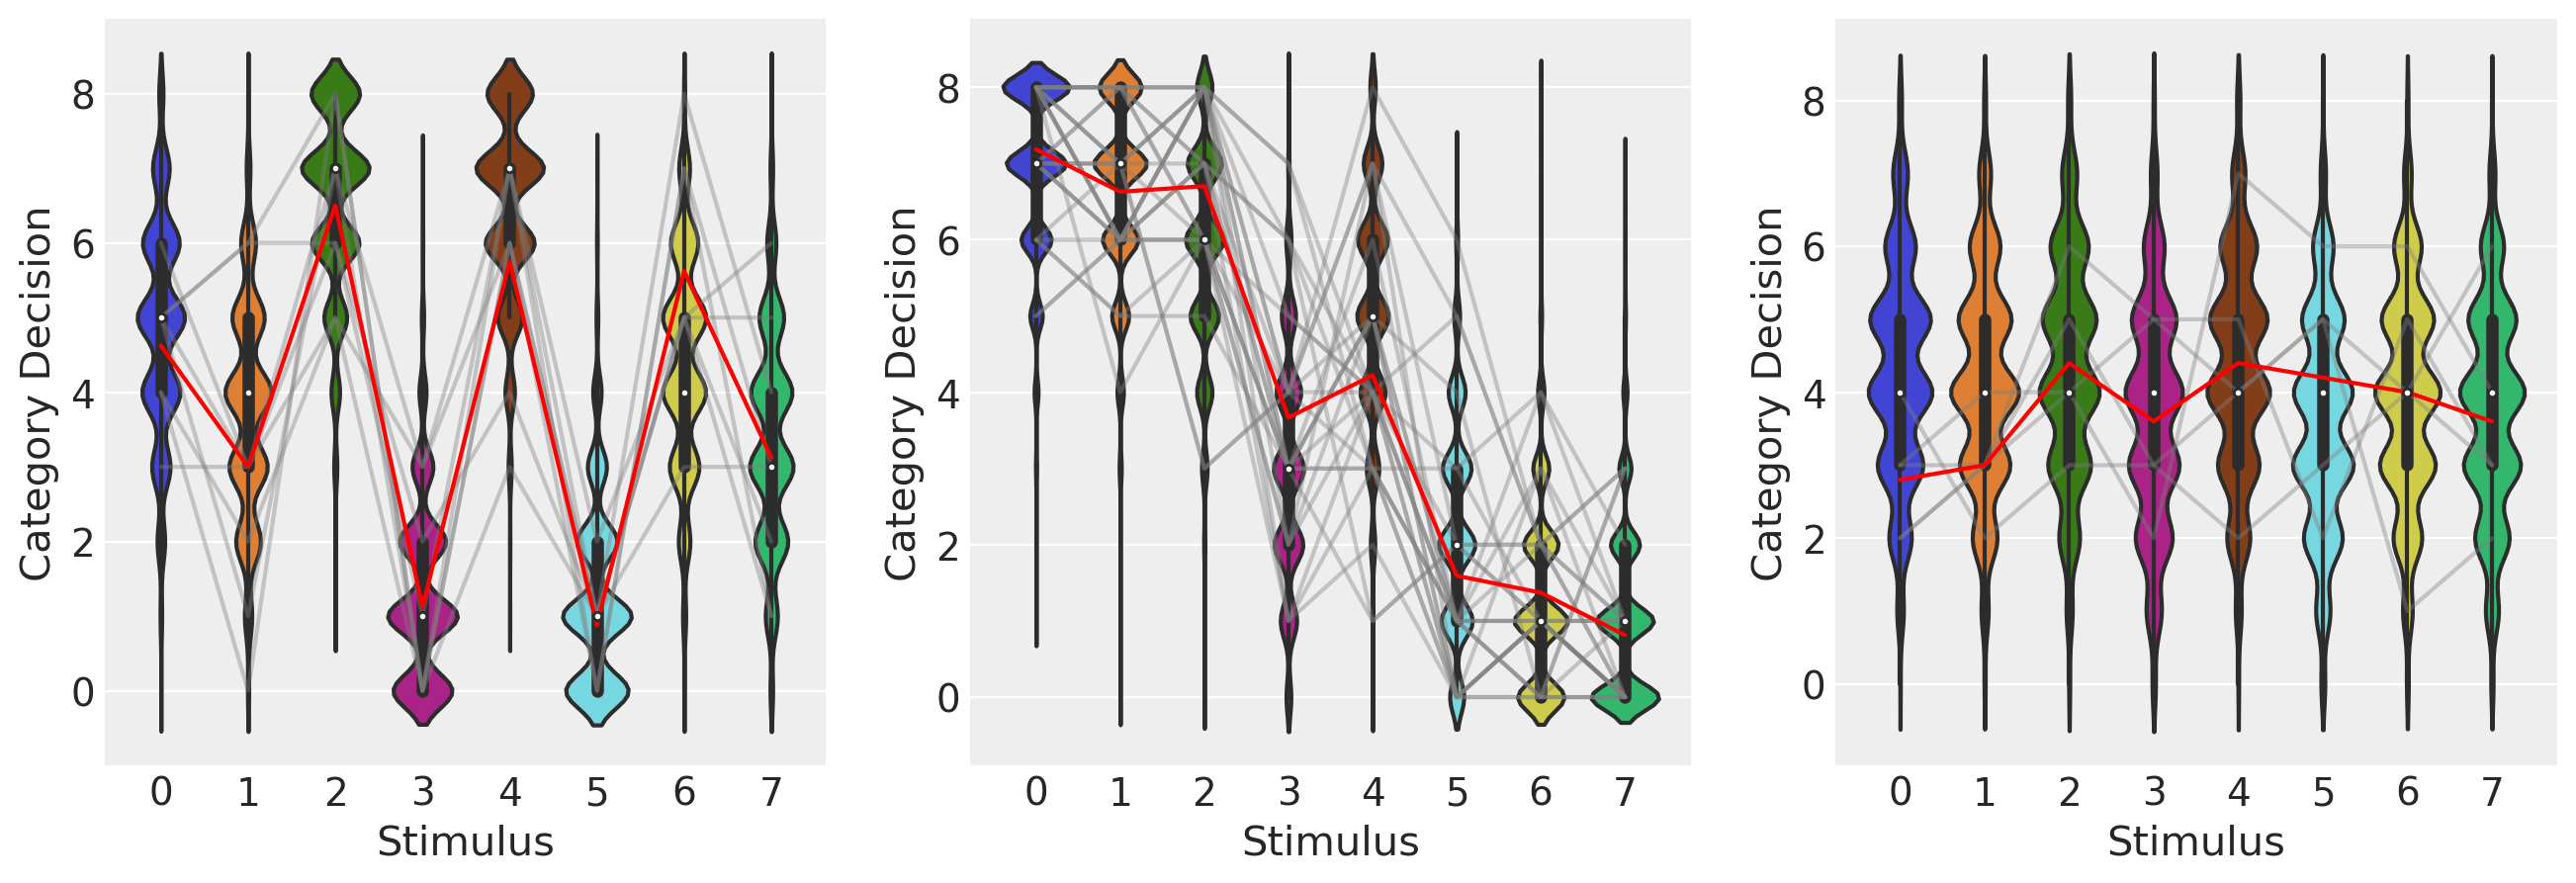

In [14]:
# Fig. 17.10
nppc_sample = 500
ppc = pm.sample_posterior_predictive(trace3, samples=nppc_sample, model=model3)

_, axes = plt.subplots(1, 3, figsize=(16, 5))
for ip in range(3):
    ax = axes[ip]
    idx = np.nonzero(z1[:, ip] > 0.5)[0]

    yipred = np.zeros((nppc_sample * len(idx), 8))
    for i, i2 in enumerate(idx):
        yipred1 = ppc["yi"][:, :, i2]
        yipred[0 + i * nppc_sample : nppc_sample + i * nppc_sample, :] = yipred1

    sns.violinplot(data=yipred, ax=ax)
    ax.plot(y2[:, idx], color="gray", alpha=0.4)
    ax.plot(np.mean(y2[:, idx], axis=1), color="red", alpha=1)
    ax.set_xticks(np.arange(8), "".join(map(str, np.arange(1, 9))))
    ax.set_yticks([0, nstim], ("B", "A"))
    ax.set_xlabel("Stimulus")
    ax.set_ylabel("Category Decision");

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3   3.8
pandas  1.0.3
numpy   1.18.1
arviz   0.7.0
seaborn 0.10.0
theano  1.0.4
last updated: Tue Apr 28 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
